Let's try testing what a pretrained neural network does!


# **Python Setup**

**Dependencies**

In [1]:
# NN Library
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset

# Math
import numpy as np
import pandas as pd

# File System Packages
import os
from google.colab import files

# Images and Display
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Widgets
import ipywidgets as widgets

**Class Setup**

In [2]:
class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
        if self.mode == 'train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]

data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(128),
    transforms.ToTensor()
])

**Function Setup**

In [3]:
# Displays an image, converts BGR to RGB
def display_img(a, title = "Original"):
    a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    plt.imshow(a), plt.title(title)
    plt.show()

# Displays an BGR image
def display_img_bw(a, title = "Original"):
    plt.imshow(a, cmap='gray'), plt.title(title)
    plt.show()

def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def load():
  uploaded = files.upload()

  files_list = []
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    files_list.append(fn)
  return files_list

def classify_images():
  files = load()
  userset = CatDogDataset(files, '/content/', mode='test', transform = test_transform)
  userloader = DataLoader(userset, batch_size = 1, shuffle=False, num_workers=2)
  display_counter = 0
  for x, fn in userloader:
    with torch.no_grad():
      output = model(x)
      pred = torch.argmax(output, dim=1)
      display_img(cv2.imread(files[display_counter]), title='Is this a %s?' % ad[pred.item()])
      display_counter += 1

def init_diy():
  train_dir = '/tmp/train/train'
  test_dir = '/tmp/test/test1/test1'
  train_files = os.listdir(train_dir)
  test_files = os.listdir(test_dir)

  cat_files = [tf for tf in train_files if 'cat' in tf]
  dog_files = [tf for tf in train_files if 'dog' in tf]

  cats = CatDogDataset(cat_files, train_dir, transform = data_transform)
  dogs = CatDogDataset(dog_files, train_dir, transform = data_transform)

  catdogs = ConcatDataset([cats, dogs])

  dataloader = DataLoader(catdogs, batch_size = 32, shuffle=True, num_workers=2)

# Rotates the image
def rotate_img(rot, angle, scale, pt_y, pt_x): 
  pt_y = int(pt_y)
  pt_x = int(pt_x)

  rows = int(len(rot) * scale)
  cols = int(len(rot[0]) * scale)

  # rotation - get proper rc length for output?
  M = cv2.getRotationMatrix2D((pt_x,pt_y),angle,scale)
  dst = cv2.warpAffine(rot,M,(cols,rows))
  return dst

def classify(rotation_angle, horizontal_flip, vertical_flip):
  global selected_img
  global selected_img_name
  rows = len(selected_img)
  cols = len(selected_img[0])
  mod_img = rotate_img(selected_img, rotation_angle, 1, rows/2, cols/2)
  if vertical_flip:
    mod_img = cv2.flip(mod_img, 0)
  if horizontal_flip:
    mod_img = cv2.flip(mod_img, 1)
  cv2.imwrite('/tmp/modified_img.jpg', mod_img)
  files = ['/tmp/modified_img.jpg']
  userset = CatDogDataset(files, '/content/', mode='test', transform = test_transform)
  userloader = DataLoader(userset, batch_size = 1, shuffle=False, num_workers=2)

  display_counter = 0
  for x, fn in userloader:
    with torch.no_grad():
      output = model(x)
      pred = torch.argmax(output, dim=1)
      display_img(cv2.imread(files[display_counter]), title='Is this a %s?' % ad[pred.item()])
      display_counter += 1

**Downloads**

In [4]:
!wget --no-check-certificate \
    https://github.com/saesus/NSF_REU_Colab/blob/master/kaggle_dataset/cat_dog.pth?raw=true \
    -O /tmp/cat_dog.pth

--2021-03-26 16:35:57--  https://github.com/saesus/NSF_REU_Colab/blob/master/kaggle_dataset/cat_dog.pth?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/saesus/NSF_REU_Colab/raw/master/kaggle_dataset/cat_dog.pth [following]
--2021-03-26 16:35:58--  https://github.com/saesus/NSF_REU_Colab/raw/master/kaggle_dataset/cat_dog.pth
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/saesus/NSF_REU_Colab/master/kaggle_dataset/cat_dog.pth [following]
--2021-03-26 16:35:58--  https://raw.githubusercontent.com/saesus/NSF_REU_Colab/master/kaggle_dataset/cat_dog.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|18

**Global Variables**

In [5]:
model = torchvision.models.densenet121(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 500),
    nn.Linear(500, 2)
)
model.load_state_dict(torch.load('/tmp/cat_dog.pth'))

# Classification Label
ad = {0:'cat', 1:'dog'}

# Image/Image Name
selected_img_name = ''
selected_img = np.array([0])

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


In [6]:
test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

# **Classify an Image!**

In [7]:
test = classify_images()

KeyboardInterrupt: ignored

In [8]:
def selected_list(x):
  global selected_img_name
  selected_img_name = x
  global selected_img
  selected_img = cv2.imread(x)

dropdown = widgets.Dropdown(
  options=load(),
  description='Input Images',
  disabled=False,
)
widgets.interact(selected_list, x=dropdown)

Saving dog1.jpg to dog1.jpg
Saving dog2.jpg to dog2.jpg
Saving dog3.jpg to dog3.jpg
Saving dog4.jpg to dog4.jpg
Saving dog5.jpg to dog5.jpg
User uploaded file "dog1.jpg" with length 8113 bytes
User uploaded file "dog2.jpg" with length 70761 bytes
User uploaded file "dog3.jpg" with length 43210 bytes
User uploaded file "dog4.jpg" with length 80459 bytes
User uploaded file "dog5.jpg" with length 29681 bytes


interactive(children=(Dropdown(description='Input Images', options=('dog1.jpg', 'dog2.jpg', 'dog3.jpg', 'dog4.…

<function __main__.selected_list>

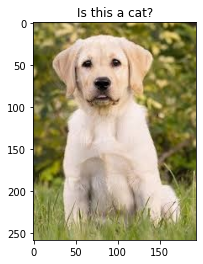

In [11]:
rotation_angle = 0
horizontal_flip = False
vertical_flip = False

classify(rotation_angle, horizontal_flip, vertical_flip)

# **Do It Yourself!** -- WIP


## **Additional Setup**

In [ ]:
!wget --no-check-certificate \
    https://github.com/saesus/NSF_REU_Colab/blob/master/kaggle_dataset/test_kaggle.zip?raw=true \
    -O /tmp/test.zip

!wget --no-check-certificate \
    https://github.com/saesus/NSF_REU_Colab/blob/master/kaggle_dataset/train_kaggle.zip?raw=true \
    -O /tmp/train.zip

!unzip /tmp/test.zip -d /tmp/test
!unzip /tmp/train.zip -d /tmp/train

## **Tune it yourself**

In [ ]:
init_diy()